# Supplementary materials : Details on generating Figure 3

This document is a supplementary material of the article *Detecting periodicities with Gaussian
processes* by N. Durrande, J. Hensman, M. Rattray and N. D. Lawrence. 

The first step is to import the required packages. This tutorial has been written with GPy 0.8.8 which includes the kernels discussed in the article. The latter can be downloaded on the [SheffieldML github page](https://github.com/SheffieldML/GPy). 

In [1]:
%pylab inline
import numpy as np
import pylab as pb
import GPy

np.random.seed(1)

Populating the interactive namespace from numpy and matplotlib


The boundary limits for the plots are set to $[0,20]$, and we consider a period of $2 \pi$. The test function for this example is $f_{test}=\sin(x)+\frac{1}{20} x$.

In [2]:
# Domain Parameters
a = 0.            # lower bound of the space
b = 20            # upper bound

# kernel parameters
per = 2*np.pi     # period
#var = 1.          # variance
#lenscl=10.        # lengthscale
#N = 20            # max frequency in the decomposition (the number of basis functions is 2N)

# test function
def ftest(X):
    return(np.sin(X) + X/20.)

# observations points and outputs
X = np.linspace(5.,15.,10)[:,None]
Y = ftest(X)

# grid for plots
Xgrid = np.linspace(a,b,100)[:,None]
Ygrid = ftest(Xgrid)

The kernel and models parameters are initialized with random value before the optimization.

In [3]:
class AperiodicMatern52(GPy.kern.Kern):
    """
    Kernel of the aperiodic subspace (up to a given frequency) of a Matern 5/2 RKHS.

    Only defined for input_dim=1.
    """

    def __init__(self, input_dim=1, variance=1., lengthscale=1., period=2.*np.pi,
            n_freq=10, lower=0., upper=4*np.pi,
            active_dims=None, name='aperiodic_Matern52'):
        self.per_kern = GPy.kern.PeriodicMatern52(input_dim, variance, lengthscale, period, n_freq, lower, upper, active_dims, name='dummy kernel')
        self.whole_kern = GPy.kern.Matern52(input_dim, variance, lengthscale, name='dummy kernel')
        GPy.kern.Kern.__init__(self, input_dim, active_dims, name)

        self.variance = GPy.core.Param('variance', np.float64(variance), GPy.core.parameterization.transformations.Logexp())
        self.lengthscale = GPy.core.Param('lengthscale', np.float64(lengthscale), GPy.core.parameterization.transformations.Logexp())
        self.period = GPy.core.Param('period', np.float64(period), GPy.core.parameterization.transformations.Logexp())
        self.link_parameters(self.variance, self.lengthscale, self.period)


    def parameters_changed(self):
        self.whole_kern.variance = self.variance * 1.
        self.per_kern.variance = self.variance * 1.

        self.whole_kern.lengthscale = self.lengthscale * 1.
        self.per_kern.lengthscale = self.lengthscale * 1.

        self.per_kern.period = self.period * 1.
    
    def K(self, X, X2=None):
        return self.whole_kern.K(X, X2) - self.per_kern.K(X, X2)

    def Kdiag(self, X):
        return np.diag(self.K(X))

    def update_gradients_full(self, dL_dK, X, X2=None):
        self.whole_kern.update_gradients_full(dL_dK, X, X2)
        self.per_kern.update_gradients_full(-dL_dK, X, X2)
        self.variance.gradient = self.whole_kern.variance.gradient + self.per_kern.variance.gradient
        self.lengthscale.gradient = self.whole_kern.lengthscale.gradient + self.per_kern.lengthscale.gradient
        self.period.gradient = self.per_kern.period.gradient



In [4]:
# kernel definitions
kp = GPy.kern.PeriodicMatern52(input_dim=1,lower=a,upper=b)
kp.period.fix()
ka = AperiodicMatern52(input_dim=1,lower=a,upper=b)
ka.period.fix()
k = kp + ka

# model definition
m = GPy.models.GPRegression(X,Y,kernel = k)
m.Gaussian_noise.variance.fix(1e-5)

# model optimization
m.randomize()
m.optimize(messages=True)


**Subfigure a: Global model $m$**

(-1.5, 2.5)

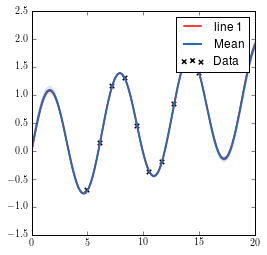

In [5]:
pb.figure(figsize=(4,4))
ax=pb.subplot(111)
pb.plot(Xgrid,Ygrid,'r-' , label='line 1', linewidth=1.5)
m.plot(plot_limits=[a,b],ax=ax)
pb.ylim([-1.5,2.5])


**Subfigure b: periodic sub-model $m_p$**

Submodels prediction require a prediction function that can take into account correlated noise:

In [6]:
def predict_submodels(x,X,Y,kernelSignal,kernelNoise):
    kxX = kernelSignal.K(x,X)
    K_1 = np.linalg.inv(kernelSignal.K(X)+kernelNoise.K(X))
    lamb = np.dot(kxX,K_1)
    mean = np.dot(lamb,Y)
    var = (kernelSignal.Kdiag(x) - np.sum(lamb.T * kxX.T,0))[:,None]
    lower = mean - 2*np.sqrt(np.abs(var))
    upper = 2*mean - lower
    return((mean,var,lower,upper))


(-1.5, 2.5)

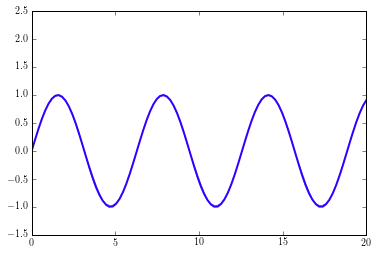

In [7]:
pred_p = predict_submodels(Xgrid,X,Y,kp,ka)

pb.figure(figsize=(4,4))
GPy.plotting.matplot_dep.base_plots.gpplot(Xgrid,pred_p[0],pred_p[2],pred_p[3])
pb.ylim([-1.5,2.5])

**Subfigure c: aperiodic sub-model $m_a$**

(-1.5, 2.5)

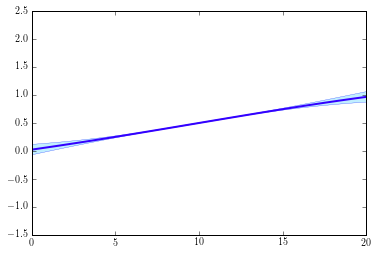

In [8]:
pred_a = predict_submodels(Xgrid,X,Y,ka,kp)

pb.figure(figsize=(4,4))
GPy.plotting.matplot_dep.base_plots.gpplot(Xgrid,pred_a[0],pred_a[2],pred_a[3])
pb.ylim([-1.5,2.5])